In [1]:
import os
import gzip
import json
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
    precision_recall_fscore_support,
    make_scorer,
)

# Baseline Logistic Regression

In [2]:
def load_jsonl_gz(path, limit=None):
    path = os.path.expanduser(path)
    rows = []
    with gzip.open(path, 'rt', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if limit is not None and i >= limit:
                break
            try:
                rows.append(json.loads(line))
            except json.JSONDecodeError:
                continue
    return pd.DataFrame(rows)


# DATA LOADING 

reviews_path = '~/Downloads/amazon_vp/All_Beauty.jsonl.gz'
meta_path    = '~/Downloads/amazon_vp/meta_All_Beauty.jsonl.gz'

df_reviews = load_jsonl_gz(reviews_path, limit=None)
df_meta    = load_jsonl_gz(meta_path,    limit=None)

print("Reviews shape:", df_reviews.shape)
print("Meta shape:", df_meta.shape)
print("Review columns:", df_reviews.columns.tolist())
print("Meta columns:", df_meta.columns.tolist())


# DATA CLEANING

# 'helpful_vote' vs 'helpful_votes'
if 'helpful_votes' not in df_reviews.columns and 'helpful_vote' in df_reviews.columns:
    df_reviews['helpful_votes'] = df_reviews['helpful_vote']

# 'sort_timestamp' vs 'timestamp'
if 'sort_timestamp' in df_reviews.columns and 'timestamp' not in df_reviews.columns:
    df_reviews['timestamp'] = df_reviews['sort_timestamp']

# check verified_purchase exists
if 'verified_purchase' not in df_reviews.columns:
    raise ValueError("verified_purchase column not found in review data.")

# parent_asin vs asin
join_key = 'asin'
if 'parent_asin' in df_reviews.columns and 'parent_asin' in df_meta.columns:
    join_key = 'parent_asin'

print("Merging on key:", join_key)

df = df_reviews.merge(df_meta, on=join_key, how='left', suffixes=('_review', '_product'))

df = df.dropna(subset=['text', 'verified_purchase'])

print("Merged shape:", df.shape)


# CHECKING FEATURES

df['review_text']  = df['text'].fillna('')
df['review_title'] = df.get('title_review', df.get('title', '')).fillna('')

# title + text
df['combined_text'] = (df['review_title'] + ' ' + df['review_text']).str.strip()

# review length (in words)
df['review_length'] = df['review_text'].apply(lambda x: len(str(x).split()))

# binary: has images in review
if 'images_review' in df.columns:
    df['has_images'] = df['images_review'].apply(lambda x: int(isinstance(x, list) and len(x) > 0))
elif 'images' in df.columns:
    df['has_images'] = df['images'].apply(lambda x: int(isinstance(x, list) and len(x) > 0))
else:
    df['has_images'] = 0

# helpful votes
if 'helpful_votes' in df.columns:
    df['helpful_votes'] = df['helpful_votes'].fillna(0).astype(float)
else:
    df['helpful_votes'] = 0.0

# ratings
if 'rating' in df.columns:
    df['rating'] = df['rating'].astype(float)
else:
    df['rating'] = np.nan

# product features (num)
df['price']          = df.get('price', np.nan).astype(float)
df['average_rating'] = df.get('average_rating', np.nan).astype(float)
df['rating_number']  = df.get('rating_number', np.nan).astype(float)

# product features (cat)
df['main_category']  = df.get('main_category', 'Unknown').fillna('Unknown')
df['store']          = df.get('store', 'Unknown').fillna('Unknown')

y = df['verified_purchase'].astype(int)

text_col = 'combined_text'
numeric_features = [
    'rating',
    'helpful_votes',
    'review_length',
    'has_images',
    'price',
    'average_rating',
    'rating_number',
]
categorical_features = [
    'main_category',
    'store',
]

# missing vals
for col in numeric_features:
    if col not in df.columns:
        df[col] = np.nan
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())

X = df[[text_col] + numeric_features + categorical_features]


# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


# text + numeric + categorical -> logistic regression

text_transformer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    stop_words='english'
)

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocess = ColumnTransformer(
    transformers=[
        ('text', text_transformer, text_col),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

clf = LogisticRegression(
    max_iter=1000,
    solver='saga',
    n_jobs=-1
)

model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', clf)
])



# TRAINING
print("Fitting model...")
model.fit(X_train, y_train)


# EVAL
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC:", roc_auc_score(y_test, y_proba))

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)


# predictor new rev
def predict_verified(
    review_text,
    review_title="",
    rating=5.0,
    helpful_votes=0,
    images_count=0,
    price=np.nan,
    average_rating=np.nan,
    rating_number=np.nan,
    main_category="All Beauty",
    store="Unknown"
):
    # is review from verified purchase? 
    
    has_images = int(images_count > 0)
    review_length = len(str(review_text).split())

    data = pd.DataFrame([{
        'combined_text': (review_title + " " + review_text).strip(),
        'rating': float(rating),
        'helpful_votes': float(helpful_votes),
        'review_length': review_length,
        'has_images': has_images,
        'price': price,
        'average_rating': average_rating,
        'rating_number': rating_number,
        'main_category': main_category,
        'store': store,
    }])

    proba = model.predict_proba(data)[0, 1]
    pred = model.predict(data)[0]

    return {
        'predicted_verified_flag': int(pred),
        'probability_verified': float(proba)
    }

Reviews shape: (701528, 10)
Meta shape: (112590, 14)
Review columns: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']
Meta columns: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together']
Merging on key: parent_asin
Merged shape: (701528, 24)
Train size: (561222, 10) Test size: (140306, 10)
Fitting model...


/Users/leyufeng/miniforge3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.16      0.26     13312
           1       0.92      0.99      0.95    126994

    accuracy                           0.92    140306
   macro avg       0.83      0.58      0.61    140306
weighted avg       0.90      0.92      0.89    140306

ROC-AUC: 0.8084679378449209
Confusion matrix:
 [[  2131  11181]
 [   720 126274]]


# Balanced Logistic Regression

In [3]:
#    - 'text', 'title_review' or 'title'
#    - 'verified_purchase'
#    - 'rating', 'helpful_votes', 'price',
#      'average_rating', 'rating_number',
#      'main_category', 'store'

# text
df['review_text']  = df['text'].fillna('')
df['review_title'] = df.get('title_review', df.get('title', '')).fillna('')
df['combined_text'] = (df['review_title'] + ' ' + df['review_text']).str.strip()

# numeric features
df['review_length'] = df['review_text'].apply(lambda x: len(str(x).split()))

if 'images_review' in df.columns:
    df['has_images'] = df['images_review'].apply(lambda x: int(isinstance(x, list) and len(x) > 0))
elif 'images' in df.columns:
    df['has_images'] = df['images'].apply(lambda x: int(isinstance(x, list) and len(x) > 0))
else:
    df['has_images'] = 0

df['helpful_votes'] = df.get('helpful_votes', 0).fillna(0).astype(float)
df['rating']        = df.get('rating', np.nan).astype(float)
df['price']         = df.get('price', np.nan).astype(float)
df['average_rating']= df.get('average_rating', np.nan).astype(float)
df['rating_number'] = df.get('rating_number', np.nan).astype(float)

df['main_category'] = df.get('main_category', 'Unknown').fillna('Unknown')
df['store']         = df.get('store', 'Unknown').fillna('Unknown')

y = df['verified_purchase'].astype(int)

text_col = 'combined_text'
numeric_features = [
    'rating',
    'helpful_votes',
    'review_length',
    'has_images',
    'price',
    'average_rating',
    'rating_number',
]
categorical_features = ['main_category', 'store']

# rep na with median
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())

X = df[[text_col] + numeric_features + categorical_features]

# train/test stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

text_transformer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    stop_words='english'
)

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocess = ColumnTransformer(
    transformers=[
        ('text', text_transformer, text_col),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

# logistic reg 
clf = LogisticRegression(
    max_iter=1000,
    solver='saga',
    n_jobs=-1,
    class_weight='balanced'
)

model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', clf)
])

print("Fitting balanced model...")
model.fit(X_train, y_train)

# default thres 0.5
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\n=== Balanced Model (Threshold 0.5) ===")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Fitting balanced model...


/Users/leyufeng/miniforge3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



=== Balanced Model (Threshold 0.5) ===
              precision    recall  f1-score   support

           0       0.29      0.68      0.40     13312
           1       0.96      0.82      0.89    126994

    accuracy                           0.81    140306
   macro avg       0.62      0.75      0.64    140306
weighted avg       0.90      0.81      0.84    140306

ROC-AUC: 0.8235556528459931
Confusion matrix:
 [[  9066   4246]
 [ 22700 104294]]


In [4]:
def find_best_threshold_for_unverified(y_true, y_proba, verbose=True):
    best_t = 0.5
    best_f1 = -1
    best_stats = None

    # thresholds over verified probability
    thresholds = np.linspace(0.1, 0.9, 17)

    for t in thresholds:
        # predict verified=1 if proba >= t, else 0
        y_pred = (y_proba >= t).astype(int)

        # compute precision/recall/f1 per class
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average=None, labels=[0, 1]
        )
        # index 0 = class 0 (unverified)
        f1_unverified = f1[0]

        if verbose:
            print(f"Threshold {t:.2f} → class 0 (unverified) F1 = {f1_unverified:.3f}, "
                  f"prec={prec[0]:.3f}, rec={rec[0]:.3f}")

        if f1_unverified > best_f1:
            best_f1 = f1_unverified
            best_t = t
            best_stats = (prec[0], rec[0], f1_unverified)

    if verbose:
        print("\nBest threshold for unverified:")
        print(f"t = {best_t:.2f}, prec={best_stats[0]:.3f}, rec={best_stats[1]:.3f}, f1={best_stats[2]:.3f}")

    return best_t, best_stats

best_t, best_stats = find_best_threshold_for_unverified(y_test, y_proba)

Threshold 0.10 → class 0 (unverified) F1 = 0.288, prec=0.714, rec=0.180
Threshold 0.15 → class 0 (unverified) F1 = 0.367, prec=0.644, rec=0.257
Threshold 0.20 → class 0 (unverified) F1 = 0.419, prec=0.579, rec=0.328
Threshold 0.25 → class 0 (unverified) F1 = 0.450, prec=0.522, rec=0.395
Threshold 0.30 → class 0 (unverified) F1 = 0.466, prec=0.471, rec=0.461
Threshold 0.35 → class 0 (unverified) F1 = 0.466, prec=0.422, rec=0.520
Threshold 0.40 → class 0 (unverified) F1 = 0.452, prec=0.373, rec=0.574
Threshold 0.45 → class 0 (unverified) F1 = 0.431, prec=0.328, rec=0.628
Threshold 0.50 → class 0 (unverified) F1 = 0.402, prec=0.285, rec=0.681
Threshold 0.55 → class 0 (unverified) F1 = 0.370, prec=0.247, rec=0.737
Threshold 0.60 → class 0 (unverified) F1 = 0.333, prec=0.211, rec=0.786
Threshold 0.65 → class 0 (unverified) F1 = 0.297, prec=0.180, rec=0.838
Threshold 0.70 → class 0 (unverified) F1 = 0.263, prec=0.155, rec=0.886
Threshold 0.75 → class 0 (unverified) F1 = 0.235, prec=0.134, re

In [5]:
# FIXING MODEL B

df['review_text']  = df['text'].fillna('')
df['review_title'] = df.get('title_review', df.get('title', '')).fillna('')
df['combined_text'] = (df['review_title'] + ' ' + df['review_text']).str.strip()

df['review_length'] = df['review_text'].apply(lambda x: len(str(x).split()))

if 'images_review' in df.columns:
    df['has_images'] = df['images_review'].apply(
        lambda x: int(isinstance(x, list) and len(x) > 0)
    )
elif 'images' in df.columns:
    df['has_images'] = df['images'].apply(
        lambda x: int(isinstance(x, list) and len(x) > 0)
    )
else:
    df['has_images'] = 0

df['helpful_votes']  = df.get('helpful_votes', 0).fillna(0).astype(float)
df['rating']         = df.get('rating', np.nan).astype(float)
df['price']          = df.get('price', np.nan).astype(float)
df['average_rating'] = df.get('average_rating', np.nan).astype(float)
df['rating_number']  = df.get('rating_number', np.nan).astype(float)

df['main_category']  = df.get('main_category', 'Unknown').fillna('Unknown')
df['store']          = df.get('store', 'Unknown').fillna('Unknown')

# label: 1 = verified, 0 = unverified
y = df['verified_purchase'].astype(int)

text_col = 'combined_text'
numeric_features = [
    'rating',
    'helpful_votes',
    'review_length',
    'has_images',
    'price',
    'average_rating',
    'rating_number',
]
categorical_features = ['main_category', 'store']

df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())

X = df[[text_col] + numeric_features + categorical_features]

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# preprocessing
text_transformer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    stop_words='english'
)

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocess = ColumnTransformer(
    transformers=[
        ('text', text_transformer, text_col),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

clf = LogisticRegression(
    max_iter=1000,
    solver='saga',
    n_jobs=-1,
    class_weight='balanced'
)

model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', clf)
])

print("Fitting balanced model...")
model.fit(X_train, y_train)


y_proba_verified = model.predict_proba(X_test)[:, 1]
y_pred_default = (y_proba_verified >= 0.5).astype(int)

print("\n=== Balanced Model (Threshold 0.5) ===")
print(classification_report(y_test, y_pred_default))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_verified))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_default))

# threshold tuning

proba_unverified = 1 - y_proba_verified

precision0, recall0, thresholds = precision_recall_curve(
    y_test,
    proba_unverified,
    pos_label=0
)

f1_0 = 2 * precision0 * recall0 / (precision0 + recall0 + 1e-12)

# choose best recall

target_precision0 = 0.60
valid_idxs = np.where(precision0 >= target_precision0)[0]

if len(valid_idxs) > 0:
    best_idx = valid_idxs[recall0[valid_idxs].argmax()]
    strategy = f"precision0 >= {target_precision0}"
else:
    best_idx = f1_0.argmax()
    strategy = "max F1 for class 0 (fallback)"

best_thresh_unverified = thresholds[best_idx]
best_thresh_verified   = 1.0 - best_thresh_unverified

print("\n=== Tuned threshold for unverified (class 0) ===")
print(f"Selection strategy: {strategy}")
print(f"Threshold on P(unverified): {best_thresh_unverified:.3f}")
print(f"Threshold on P(verified)  : {best_thresh_verified:.3f}")
print(f"precision0={precision0[best_idx]:.3f}, recall0={recall0[best_idx]:.3f}, f1_0={f1_0[best_idx]:.3f}")


y_pred_tuned = (y_proba_verified >= best_thresh_verified).astype(int)

print("\n=== Balanced Model with Tuned Threshold (better for unverified) ===")
print(classification_report(y_test, y_pred_tuned))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_tuned))
print("ROC-AUC (unchanged):", roc_auc_score(y_test, y_proba_verified))

Fitting balanced model...


/Users/leyufeng/miniforge3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



=== Balanced Model (Threshold 0.5) ===
              precision    recall  f1-score   support

           0       0.29      0.68      0.40     13312
           1       0.96      0.82      0.89    126994

    accuracy                           0.81    140306
   macro avg       0.62      0.75      0.64    140306
weighted avg       0.90      0.81      0.84    140306

ROC-AUC: 0.8235557321104132
Confusion matrix:
 [[  9067   4245]
 [ 22698 104296]]

=== Tuned threshold for unverified (class 0) ===
Selection strategy: precision0 >= 0.6
Threshold on P(unverified): 0.819
Threshold on P(verified)  : 0.181
precision0=0.600, recall0=0.300, f1_0=0.400

=== Balanced Model with Tuned Threshold (better for unverified) ===
              precision    recall  f1-score   support

           0       0.60      0.30      0.40     13312
           1       0.93      0.98      0.95    126994

    accuracy                           0.91    140306
   macro avg       0.77      0.64      0.68    140306
weighted a

# Final Model: Tuned Logistic Regression (GridSearchCV + Threshold Tuning)

In [6]:
df['review_text']  = df['text'].fillna('')
df['review_title'] = df.get('title_review', df.get('title', '')).fillna('')
df['combined_text'] = (df['review_title'] + ' ' + df['review_text']).str.strip()

df['review_length'] = df['review_text'].apply(lambda x: len(str(x).split()))

if 'images_review' in df.columns:
    df['has_images'] = df['images_review'].apply(
        lambda x: int(isinstance(x, list) and len(x) > 0)
    )
elif 'images' in df.columns:
    df['has_images'] = df['images'].apply(
        lambda x: int(isinstance(x, list) and len(x) > 0)
    )
else:
    df['has_images'] = 0

df['helpful_votes']  = df.get('helpful_votes', 0).fillna(0).astype(float)
df['rating']         = df.get('rating', np.nan).astype(float)
df['price']          = df.get('price', np.nan).astype(float)
df['average_rating'] = df.get('average_rating', np.nan).astype(float)
df['rating_number']  = df.get('rating_number', np.nan).astype(float)

df['main_category']  = df.get('main_category', 'Unknown').fillna('Unknown')
df['store']          = df.get('store', 'Unknown').fillna('Unknown')

y = df['verified_purchase'].astype(int)

text_col = 'combined_text'
numeric_features = [
    'rating',
    'helpful_votes',
    'review_length',
    'has_images',
    'price',
    'average_rating',
    'rating_number',
]
categorical_features = ['main_category', 'store']

df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())
X = df[[text_col] + numeric_features + categorical_features]

# split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# preprocessing

text_transformer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    stop_words='english'
)

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocess = ColumnTransformer(
    transformers=[
        ('text', text_transformer, text_col),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

base_clf = LogisticRegression(
    max_iter=1000,
    solver='saga',
    n_jobs=-1,
    class_weight='balanced'
)

pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', base_clf)
])

# hyperparam tuning

def f1_class0(y_true, y_pred):
    from sklearn.metrics import f1_score
    return f1_score(y_true, y_pred, pos_label=0)

scorer = make_scorer(f1_class0)

param_grid = {
    'clf__C': [0.1, 0.5, 1.0, 2.0, 5.0]
}

print("Fitting tuned logistic regression with CV...")
grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring=scorer,
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best C from CV:", grid.best_params_)

model = grid.best_estimator_

# threshold 0.5

y_proba_verified = model.predict_proba(X_test)[:, 1]
y_pred_default = (y_proba_verified >= 0.5).astype(int)

print("\n=== Tuned Logistic (Threshold 0.5) ===")
print(classification_report(y_test, y_pred_default))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_verified))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_default))


proba_unverified = 1 - y_proba_verified

precision0, recall0, thresholds = precision_recall_curve(
    y_test,
    proba_unverified,
    pos_label=0
)

f1_0 = 2 * precision0 * recall0 / (precision0 + recall0 + 1e-12)
best_idx = f1_0.argmax()

best_thresh_unverified = thresholds[best_idx]
best_thresh_verified   = 1.0 - best_thresh_unverified

print("\n=== Best F1 point for class 0 (unverified) ===")
print(f"Threshold on P(unverified): {best_thresh_unverified:.3f}")
print(f"Threshold on P(verified)  : {best_thresh_verified:.3f}")
print(f"precision0={precision0[best_idx]:.3f}, recall0={recall0[best_idx]:.3f}, f1_0={f1_0[best_idx]:.3f}")

y_pred_tuned = (y_proba_verified >= best_thresh_verified).astype(int)

print("\n=== Tuned Logistic + Tuned Threshold (good balance for unverified) ===")
print(classification_report(y_test, y_pred_tuned))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_tuned))
print("ROC-AUC (unchanged):", roc_auc_score(y_test, y_proba_verified))

Fitting tuned logistic regression with CV...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/Users/leyufeng/miniforge3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/leyufeng/miniforge3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/leyufeng/miniforge3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/leyufeng/miniforge3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/leyufeng/miniforge3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/leyufeng/miniforge3/lib/python3.12/sit

Best C from CV: {'clf__C': 5.0}

=== Tuned Logistic (Threshold 0.5) ===
              precision    recall  f1-score   support

           0       0.29      0.68      0.40     13312
           1       0.96      0.82      0.89    126994

    accuracy                           0.81    140306
   macro avg       0.62      0.75      0.64    140306
weighted avg       0.90      0.81      0.84    140306

ROC-AUC: 0.823788761815746
Confusion matrix:
 [[  9065   4247]
 [ 22707 104287]]

=== Best F1 point for class 0 (unverified) ===
Threshold on P(unverified): 0.697
Threshold on P(verified)  : 0.303
precision0=0.467, recall0=0.469, f1_0=0.468

=== Tuned Logistic + Tuned Threshold (good balance for unverified) ===
              precision    recall  f1-score   support

           0       0.47      0.47      0.47     13312
           1       0.94      0.94      0.94    126994

    accuracy                           0.90    140306
   macro avg       0.71      0.71      0.71    140306
weighted avg    

### Helper function to flag suspicious reviews

In [7]:
def flag_suspicious_reviews(df_reviews_raw, model, threshold_verified=0.7, top_n=50):
    tmp = df_reviews_raw.copy()

    tmp['review_text']  = tmp['text'].fillna('')
    tmp['review_title'] = tmp.get('title_review', tmp.get('title', '')).fillna('')
    tmp['combined_text'] = (tmp['review_title'] + ' ' + tmp['review_text']).str.strip()

    tmp['review_length'] = tmp['review_text'].apply(lambda x: len(str(x).split()))

    if 'images_review' in tmp.columns:
        tmp['has_images'] = tmp['images_review'].apply(lambda x: int(isinstance(x, list) and len(x) > 0))
    elif 'images' in tmp.columns:
        tmp['has_images'] = tmp['images'].apply(lambda x: int(isinstance(x, list) and len(x) > 0))
    else:
        tmp['has_images'] = 0

    tmp['helpful_votes'] = tmp.get('helpful_votes', 0).fillna(0).astype(float)
    tmp['rating']        = tmp.get('rating', np.nan).astype(float)
    tmp['price']         = tmp.get('price', np.nan).astype(float)
    tmp['average_rating']= tmp.get('average_rating', np.nan).astype(float)
    tmp['rating_number'] = tmp.get('rating_number', np.nan).astype(float)

    tmp['main_category'] = tmp.get('main_category', 'Unknown').fillna('Unknown')
    tmp['store']         = tmp.get('store', 'Unknown').fillna('Unknown')

    numeric_features = [
        'rating',
        'helpful_votes',
        'review_length',
        'has_images',
        'price',
        'average_rating',
        'rating_number',
    ]
    tmp[numeric_features] = tmp[numeric_features].fillna(tmp[numeric_features].median())

    X_all = tmp[['combined_text'] + numeric_features + ['main_category', 'store']]

    # predict probabilities of verified
    proba_verified = model.predict_proba(X_all)[:, 1]
    tmp['prob_verified'] = proba_verified
    tmp['suspicious_flag'] = (tmp['prob_verified'] < threshold_verified).astype(int)

    # most suspicious = lowest prob_verified
    suspicious = tmp.sort_values('prob_verified', ascending=True).head(top_n)

    return suspicious[['rating', 'helpful_votes', 'review_text', 'prob_verified', 'suspicious_flag']]

### Final evaluation on test set

In [8]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC:", auc)

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.68      0.40     13312
           1       0.96      0.82      0.89    126994

    accuracy                           0.81    140306
   macro avg       0.62      0.75      0.64    140306
weighted avg       0.90      0.81      0.84    140306

Confusion matrix:
 [[  9065   4247]
 [ 22707 104287]]
ROC-AUC: 0.823788761815746


### Precision-recall curve plot for unverified reviews

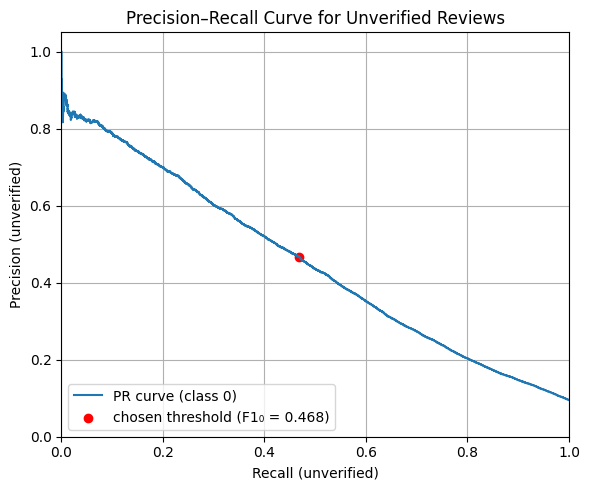

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.plot(recall0, precision0, label="PR curve (class 0)")
plt.scatter(
    recall0[best_idx],
    precision0[best_idx],
    color="red",
    label=f"chosen threshold (F1₀ = {f1_0[best_idx]:.3f})"
)
plt.xlabel("Recall (unverified)")
plt.ylabel("Precision (unverified)")
plt.title("Precision–Recall Curve for Unverified Reviews")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()